### Look at behavioral correlates of belief state value, re-factor and run a bunch of analyses from 20240612_some_trial_durations.ipynb but on Belief State Values. 
Specifically, look at: 
- Belief state values as function of num trials after block switch
- Probability of correct as a function of belief state value
- Probability of choosing card with preferred feature as a function of belief state value
- Decision time as a function of belief state value
- Time to cross fixate as a function of belief state value

In [16]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *

import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load all the data

In [60]:
num_bins = 10

def get_sess_beh(row, beh_path):
    session = row.session_name
    behavior_path = beh_path.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_relative_block_position(beh, num_bins)
    beh = behavioral_utils.get_beliefs_per_session(beh, session)
    beh["PreferredBelief"] = beh[[f"{feat}Prob" for feat in FEATURES]].idxmax(axis=1).apply(lambda x: x[:-4])
    beh["session"] = session
    return beh

In [61]:
# Monkey S
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)
beh_path = SESS_BEHAVIOR_PATH
res = pd.concat(sessions.apply(lambda x: get_sess_beh(x, beh_path), axis=1).values)
res["CombinedIdx"] = np.arange(len(res))

In [62]:
res

,index,TrialNumber,BlockNumber,TrialAfterRuleChange,TaskInterrupt,ConditionNumber,Response,ItemChosen,TrialType,CurrentRule,...,MAGENTAProb,YELLOWProb,ESCHERProb,POLKADOTProb,RIPPLEProb,SWIRLProb,BeliefStateValue,PreferredBelief,session,CombinedIdx
0,0,49,2,0,NaN,2258,Incorrect,2.0,11,SQUARE,...,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.328915,CIRCLE,20180709,0
1,1,50,2,1,NaN,1881,Incorrect,2.0,11,SQUARE,...,0.097528,0.040750,0.097528,0.040750,0.097528,0.097528,0.331893,SQUARE,20180709,1
2,2,51,2,2,NaN,2206,Incorrect,3.0,11,SQUARE,...,0.110206,0.056439,0.110206,0.056439,0.110206,0.046048,0.334192,ESCHER,20180709,2
3,3,52,2,3,NaN,2005,Correct,0.0,11,SQUARE,...,0.051942,0.072522,0.124313,0.072522,0.124313,0.026120,0.335530,SQUARE,20180709,3
4,4,53,2,4,NaN,1834,Correct,0.0,11,SQUARE,...,0.106762,0.057577,0.090212,0.057577,0.090212,0.067819,0.338974,SQUARE,20180709,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,853,876,26,13,NaN,2654,Correct,0.0,4,CYAN,...,0.015972,0.014386,0.042511,0.016779,0.023828,0.026757,0.509555,CYAN,20180910,28008
854,854,877,26,14,NaN,2557,Correct,0.0,4,CYAN,...,0.014770,0.014097,0.026026,0.015112,0.043323,0.019344,0.526579,CYAN,20180910,28009
855,855,878,26,15,NaN,2696,Correct,0.0,4,CYAN,...,0.013923,0.013645,0.018585,0.014065,0.025749,0.037857,0.533984,CYAN,20180910,28010
856,856,879,26,16,NaN,2567,Correct,0.0,4,CYAN,...,0.013548,0.013433,0.037037,0.013607,0.018437,0.023442,0.540309,CYAN,20180910,28011


### Belief state values as function of num trials after block switch
Maybe just look at 1st 20 trials

<Axes: xlabel='TrialAfterRuleChange', ylabel='BeliefStateValue'>

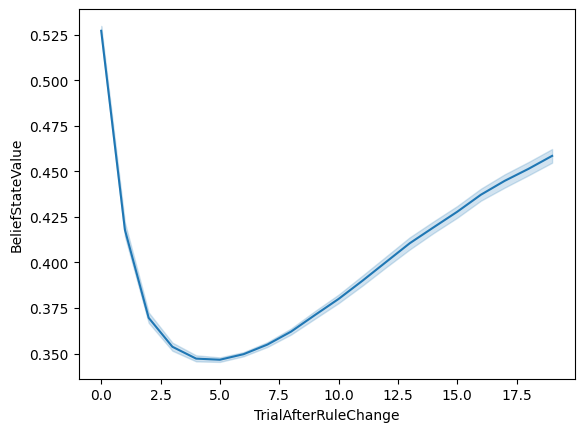

In [63]:
first_20 = res[res.TrialAfterRuleChange < 20]
fig, ax = plt.subplots()
sns.lineplot(first_20, x="TrialAfterRuleChange", y="BeliefStateValue", ax=ax)

### Probability of correct as a function of belief state value

In [64]:
out, bins = pd.cut(res["BeliefStateValue"], 10, labels=False, retbins=True)
res["BeliefStateValueBin"] = out
res["BeliefStateValueLabel"] = bins[out]


<Axes: xlabel='BeliefStateValueLabel', ylabel='ProbCorrect'>

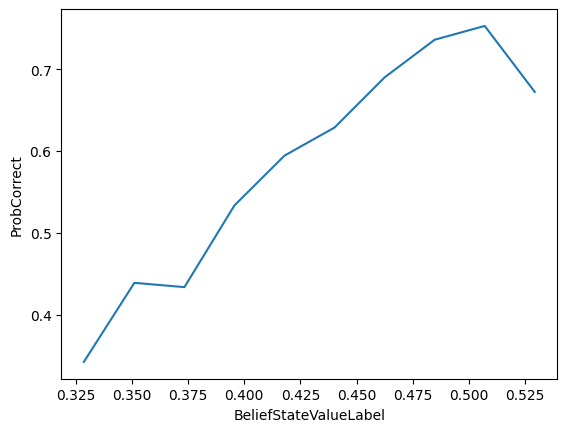

In [65]:
def calc_prob_correct(group):
    return len(group[group.Response == "Correct"]) / len(group)
prob_correct = res.groupby("BeliefStateValueBin", group_keys=False).apply(calc_prob_correct).reset_index(name='ProbCorrect')
prob_correct["BeliefStateValueLabel"] = bins[prob_correct["BeliefStateValueBin"].values]
fig, ax = plt.subplots()
sns.lineplot(prob_correct, x="BeliefStateValueLabel", y="ProbCorrect", ax=ax)


### Probability of preferred feat being chosen as a function of belief state value

<Axes: xlabel='BeliefStateValueLabel', ylabel='ProbPreferredChosen'>

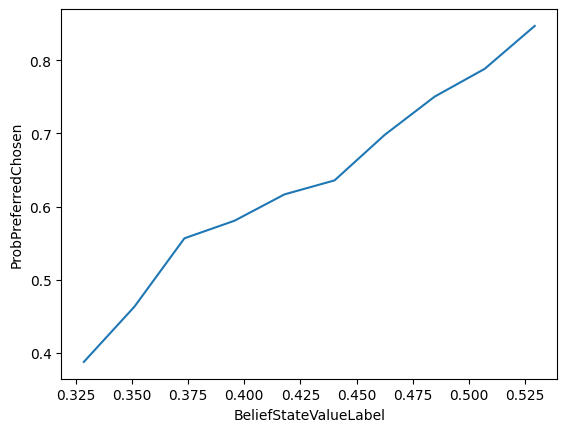

In [68]:
def calc_prob_preferred_chosen(group):
    group["PreferredBeliefChosen"] = group.apply(lambda x: x[FEATURE_TO_DIM[x.PreferredBelief]] == x.PreferredBelief, axis=1)
    return len(group[group.PreferredBeliefChosen]) / len(group)
prob_preferred_chosen = res.groupby("BeliefStateValueBin", group_keys=False).apply(calc_prob_preferred_chosen).reset_index(name='ProbPreferredChosen')
prob_preferred_chosen["BeliefStateValueLabel"] = bins[prob_preferred_chosen["BeliefStateValueBin"].values]
sns.lineplot(prob_preferred_chosen, x="BeliefStateValueLabel", y="ProbPreferredChosen")

### Decision time as a function of belief state value

In [69]:
res["DecisionTime"] = res.FeedbackOnset - 800 - res.StimOnset

Text(0, 0.5, 'Decision Time (ms)')

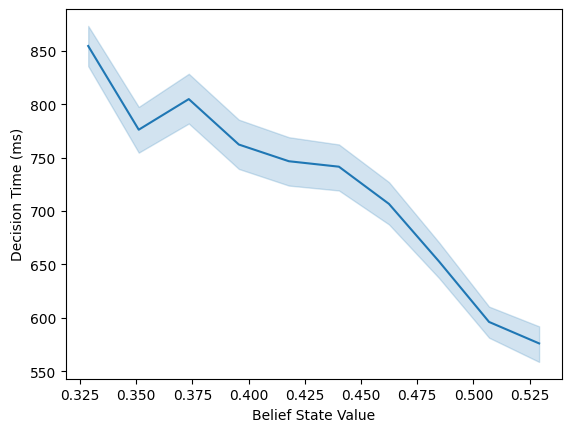

In [70]:
fig, ax = plt.subplots()
sns.lineplot(res, x="BeliefStateValueLabel", y="DecisionTime", ax=ax)
ax.set_xlabel("Belief State Value")
ax.set_ylabel("Decision Time (ms)")

### Cross fixation time as a function of belief state value

In [71]:
res["Time to Cross Fixate (ms)"] = res.FixationOnCross - res.FixCrossOn

Text(0, 0.5, 'Time to cross fixate (ms)')

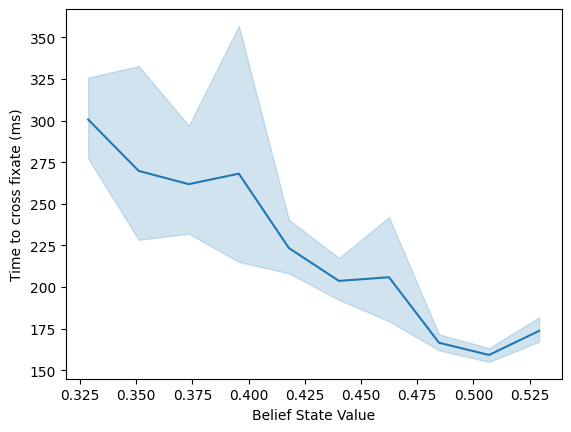

In [72]:
fig, ax = plt.subplots()
# res_sub = res[res["Time to Cross Fixate (ms)"] < 5000]
sns.lineplot(res, x="BeliefStateValueLabel", y="Time to Cross Fixate (ms)", ax=ax)
ax.set_xlabel("Belief State Value")
ax.set_ylabel("Time to cross fixate (ms)")